# Exercises

In [1]:
# get all files from the notebook here
!git clone https://github.com/irenetiem/population-methods-IT

import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("/population-methods-IT/blob/main/01-bayes-decoding/bayes-decoding.ipynb"))
# from utils import download_data

import urllib.request
from os import remove
import zipfile
from pathlib import Path


def download_data(url):

    if url.endswith('download'):
        URL = url
    else:
        URL = '/'.join((url, 'download'))

    if URL:
        response = urllib.request.urlopen(URL)
        data = response.read()
        response.close()

        with open('data.zip', 'wb') as f:
            f.write(data)

    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

    remove('data.zip')

sns.set_theme(context='notebook',style='white',font_scale=1,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

Cloning into 'population-methods-IT'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 268 (delta 55), reused 34 (delta 12), pack-reused 160 (from 1)
Receiving objects: 100% (268/268), 21.50 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
download_data('https://surfdrive.surf.nl/files/index.php/s/TliAW2xObyy0keu')

In [3]:
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps']
n_cells = len(spikes)

def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')

interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding?

### Code for data generation

In [4]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

In [5]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [6]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [7]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])

for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [8]:
# sampling here
# keep parameters

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []#np.zeros(n_cells)

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    # for j in range(len(t_sp)):
    #     spikes.append(t_sp[j]) # change shape of spikes
    spikes.append(t_sp)

In [10]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('/content/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [27]:
from scipy.stats import poisson

In [41]:
# A

# define func to decode and get MSE with sample of specific percentgae
def decode_and_MSE(percentage, x, t, spikes, track_length, fps):

  # get percentage of data sampled randomly
  indices = np.random.choice(len(spikes), int(len(spikes)*percentage), replace=False)
  subset = [spikes[i] for i in indices]

  # decode
  spike_positions = [np.interp(s, t, x) for s in subset]
  space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

  # we compute histograms for each cell
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
  spikes_hist = np.asarray(spikes_hist)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy
  spikes_count= [np.histogram(s,t)[0] for s in subset]
  spikes_count = np.asarray(spikes_count).T #


  true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
  decoding_times = t[:-1]

  x_decoded = np.zeros_like(true_x)

  for t_bin in tqdm(range(len(decoding_times))):
      if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
          posterior = np.empty(firing_rate_maps.shape[-1])

          for i in range(len(posterior)):
              # Note that we work with log so that we can sum probabilities
              # instead of multiplying them
              #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
              posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(10,-15))


          x_decoded[t_bin] = space_bins[np.argmax(posterior)]
      else:
          x_decoded[t_bin] = np.nan

  # error distribution
  mse = np.sqrt((true_x-x_decoded)**2)
  # print(mse)

  return np.nanmedian(mse) # otherwise only nan

In [ ]:
fractions = np.arange(0.1, 1.1, 0.1) # don't start at 0, then there won't be data
track_mse = np.zeros_like(fractions)

for i, frac in enumerate(fractions):
  mse = decode_and_MSE(percentage=frac, x=x, t=t, spikes=spikes, track_length=track_length, fps=fps)
  track_mse[i] = mse

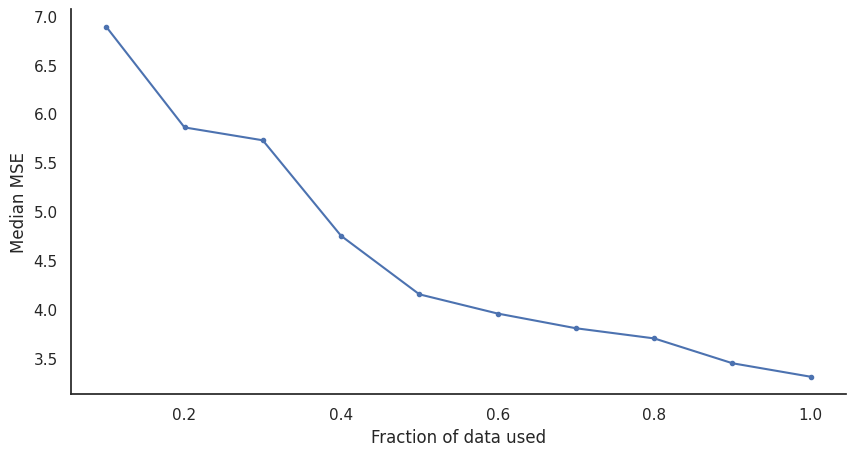

In [40]:
plt.figure(figsize=(10,5))
plt.plot(fractions, track_mse, marker = '.')#, linewidth = 0)
plt.xlabel('Fraction of data used')
plt.ylabel('Median MSE')
plt.show()

## B

10 out of 100 cells corresponds with 10%, so a fraction of 0.1. So for this exercise, we look at the graph above again and see that a larger fractions gives a smaller mean error. Depending on what MSE is needed to get reliable decoding results, the number of neurons can be read from the graph.

It does not really look like it reaches an asymptote, especially as the value at 0.8 is quite high, I will need to calculate more points to check this.

In [ ]:
fractions_adj = np.arange(0.15, 1.05, 0.1) # don't start at 0, then there won't be data
track_mse_adj = np.zeros_like(fractions)

for i, frac in enumerate(fractions_adj):
  mse = decode_and_MSE(percentage=frac, x=x, t=t, spikes=spikes, track_length=track_length, fps=fps)
  track_mse_adj[i] = mse

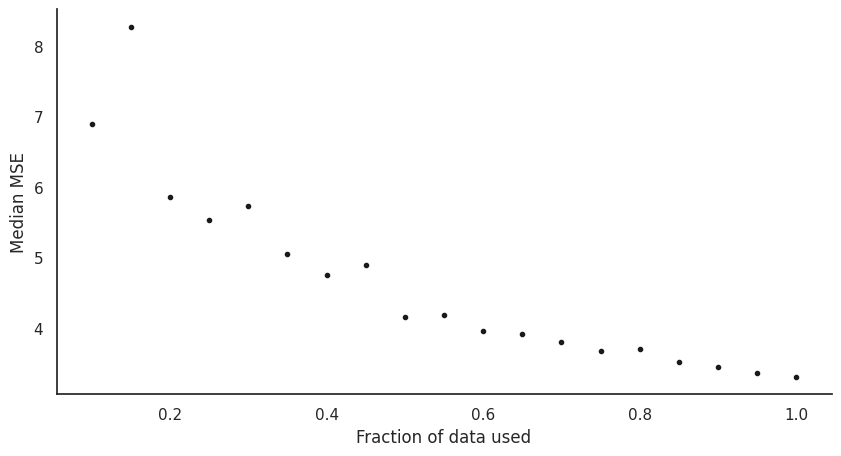

In [44]:
plt.figure(figsize=(10,5))
plt.scatter(fractions, track_mse, marker = '.', color = 'k')#, linewidth = 0)
plt.scatter(fractions_adj, track_mse_adj, marker = '.', color = 'k')
plt.xlabel('Fraction of data used')
plt.ylabel('Median MSE')
plt.show()

Still does not look much like an asymptote.

## C

generating new data

In [48]:
# try a few values for noise firing rate

nrfs = np.array([0.1, 0.3, 0.7, 1, 5])
track_mse_different_noises = np.zeros_like(nrfs)

for j, noise_firing_rate in enumerate(nrfs):
  sampling_rate = 10000.
  t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
  x_sampling = np.floor(np.interp(t_sampling, t, x))
  spikes = []

  for i in range(n_cells):
      inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
      spikes_loc = np.random.poisson(inst_rate/sampling_rate)
      sp = np.argwhere(spikes_loc)
      t_sp = t_sampling[sp]
      spikes.append(t_sp)

  # calculate the MSE using the new spikes data and a fraction of 1
  mse = decode_and_MSE(percentage=1, x=x, t=t, spikes=spikes, track_length=track_length, fps=fps)
  track_mse_different_noises[j] = mse

100%|██████████| 4476/4476 [00:25<00:00, 174.72it/s]


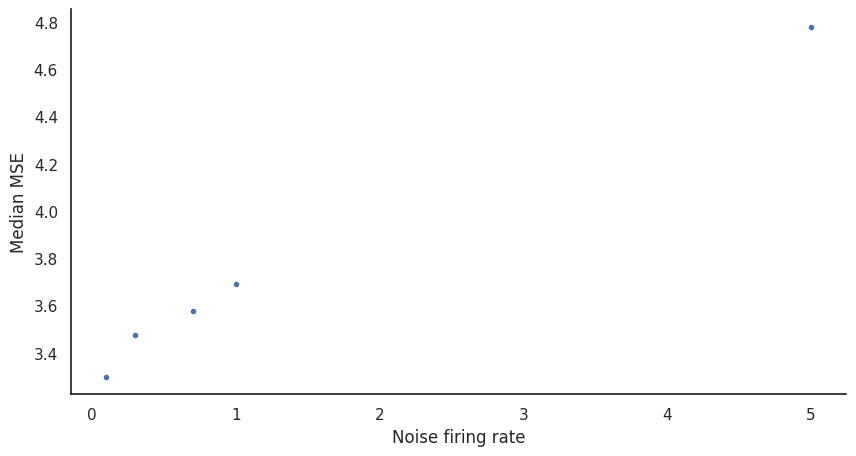

In [52]:
plt.figure(figsize=(10,5))
plt.scatter(nrfs, track_mse_different_noises, marker = '.')
plt.xlabel('Noise firing rate')
plt.ylabel('Median MSE')
plt.show()

As can be expected, the error increases (somewhat linearly) as the noise increases.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$.
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [56]:
# define a decoder for both models that plots the MSE graph

def decode_and_plot_other_post(percentage, x, t, spikes, track_length, fps):

  # get percentage of data sampled randomly
  indices = np.random.choice(len(spikes), int(len(spikes)*percentage), replace=False)
  subset = [spikes[i] for i in indices]

  # decode
  spike_positions = [np.interp(s, t, x) for s in subset]
  space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

  # we compute histograms for each cell
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
  spikes_hist = np.asarray(spikes_hist)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy
  spikes_count= [np.histogram(s,t)[0] for s in subset]
  spikes_count = np.asarray(spikes_count).T #


  true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
  decoding_times = t[:-1]

  x_decoded = np.zeros_like(true_x)

  for t_bin in tqdm(range(len(decoding_times))):
      if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
          posterior = np.empty(firing_rate_maps.shape[-1])

          for i in range(len(posterior)):
              # Note that we work with log so that we can sum probabilities
              # instead of multiplying them
              posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
              # posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(10,-15))


          x_decoded[t_bin] = space_bins[np.argmax(posterior)]
      else:
          x_decoded[t_bin] = np.nan

  # error distribution
  mse = np.sqrt((true_x-x_decoded)**2)
  # print(mse)

  mse = np.sqrt((true_x-x_decoded)**2)
  sns.histplot(mse, label = 'other method')
  plt.axvline(x = np.nanmedian(mse),c='r')
  print(f'Median error: {np.nanmedian(mse)} cm')
  # return np.nanmedian(mse) # otherwise only nan

def decode_and_plot(percentage, x, t, spikes, track_length, fps):

  # get percentage of data sampled randomly
  indices = np.random.choice(len(spikes), int(len(spikes)*percentage), replace=False)
  subset = [spikes[i] for i in indices]

  # decode
  spike_positions = [np.interp(s, t, x) for s in subset]
  space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

  # we compute histograms for each cell
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
  spikes_hist = np.asarray(spikes_hist)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy
  spikes_count= [np.histogram(s,t)[0] for s in subset]
  spikes_count = np.asarray(spikes_count).T #


  true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
  decoding_times = t[:-1]

  x_decoded = np.zeros_like(true_x)

  for t_bin in tqdm(range(len(decoding_times))):
      if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
          posterior = np.empty(firing_rate_maps.shape[-1])

          for i in range(len(posterior)):
              # Note that we work with log so that we can sum probabilities
              # instead of multiplying them
              # posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
              posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(10,-15))


          x_decoded[t_bin] = space_bins[np.argmax(posterior)]
      else:
          x_decoded[t_bin] = np.nan

  # error distribution
  mse = np.sqrt((true_x-x_decoded)**2)
  # print(mse)

  mse = np.sqrt((true_x-x_decoded)**2)
  sns.histplot(mse, label = 'original method', color = 'g')
  plt.axvline(x = np.nanmedian(mse),c='k')
  print(f'Median error: {np.nanmedian(mse)} cm')
  # return np.nanmedian(mse) # otherwise only nan

100%|██████████| 4476/4476 [00:28<00:00, 157.00it/s]


Median error: 10.483314794215808 cm


100%|██████████| 4476/4476 [00:25<00:00, 178.10it/s]


Median error: 4.779205069124423 cm


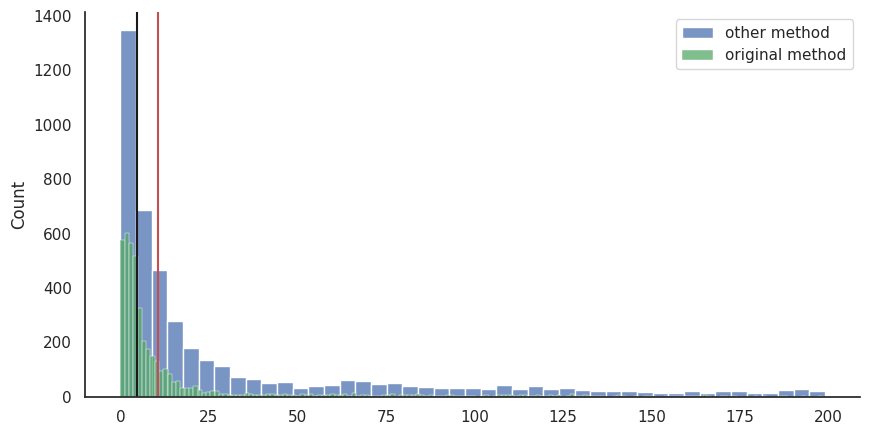

In [57]:
decode_and_plot_other_post(percentage  = 1, x=x, t=t, spikes=spikes, track_length=track_length, fps=fps)
decode_and_plot(percentage  = 1, x=x, t=t, spikes=spikes, track_length=track_length, fps=fps)

plt.legend()
plt.show()

It seems that the other method of calculation posteriors on the same data leads to a larger MSE and wider spread distribution of errors. This might be beacause `poisson.pmf` calculates the logarithm directly and is better for numerically stable calculations.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


## A

Text(0, 0.5, 'cell #')

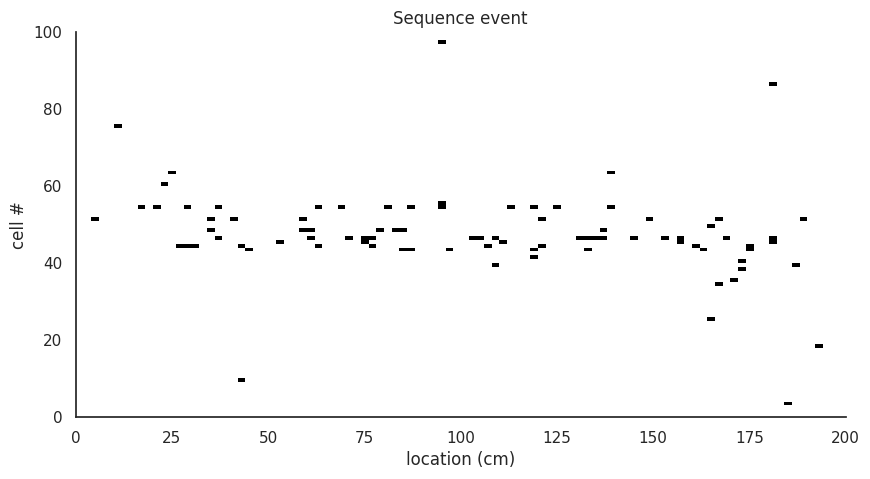

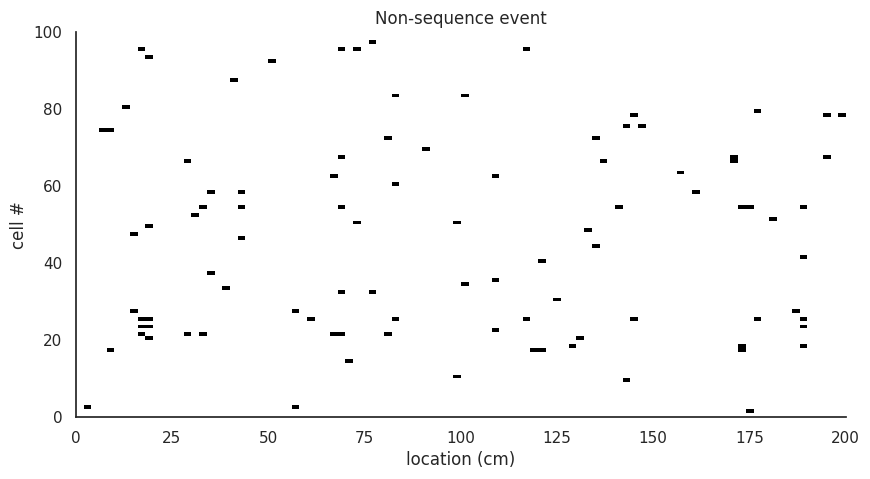

In [60]:
# generate data

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length

    #store reactivation sequence
    reactivation_events[event,:] = x_react


    # Generate spikes according to the location being reactivated in this event

    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1

pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps]
sorted_idxs = np.argsort(pfc_idxs)


event = 50
plt.figure(figsize=(10,5))
plt.title('Sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

event = 150
plt.figure(figsize=(10,5))
plt.title('Non-sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

In [61]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]

/tmp/ipython-input-61-2865794393.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
/tmp/ipython-input-61-2865794393.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
/tmp/ipython-input-61-2865794393.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
/tmp/ipython-input-61-2865794393.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
/tmp/ipython-input-61-2865794393.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
/tmp/ipython-input-61-2865794393.py:50: ConstantInputWa